# Prever candles 30M EURUSD

In [23]:
import os
import json
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from core.model import Model
from core.data_processor import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Configs

In [2]:
model_path = 'saved_models/lstm-EURUSD-30M-seq1000-output-ohlc-ep100-30042020-012133-e100.h5'
normalise = True
seq_len = 1000
cols = ["Close","Open","High","Low"]

df_2017 = pd.read_csv('data/EURUSD-2017_01_01-2017_12_31.csv')
df_2018 = pd.read_csv('data/EURUSD-2018_01_01-2018_12_31.csv')

## Carregar model

In [3]:
model = Model()
model.load_model(model_path)
model.model.summary()


[Model] Loading model from file saved_models/lstm-EURUSD-30M-seq1000-output-ohlc-ep100-30042020-012133-e100.h5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 999, 50)           11000     
_________________________________________________________________
dropout (Dropout)            (None, 999, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 204       
Total params: 31,404
Trainable params: 31,404
Non-trainable p

## Preparandos dados

In [16]:
# 2017
data_test_2017 = df_2017.get(cols).values
len_test_2017   = len(data_test_2017)
x_test_2017, y_test_2017, closes_2017 =  get_test_data(data_test_2017, len_test_2017, seq_len, normalise, debug=True)

100%|██████████| 10338/10338 [00:24<00:00, 419.75it/s]


In [17]:
#2018
data_test_2018 = df_2018.get(cols).values
len_test_2018   = len(data_test_2018)
x_test_2018, y_test_2018, closes_2018 = get_test_data(data_test_2018, len_test_2018, seq_len, normalise, debug=True)

100%|██████████| 10967/10967 [00:25<00:00, 423.40it/s]


## Preços
Preços de fechamento de 2017 e 2018

/home/danilo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


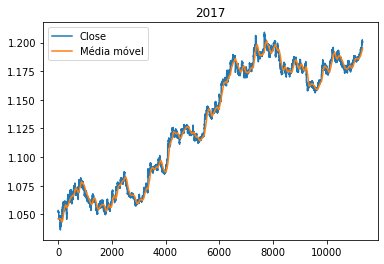

/home/danilo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


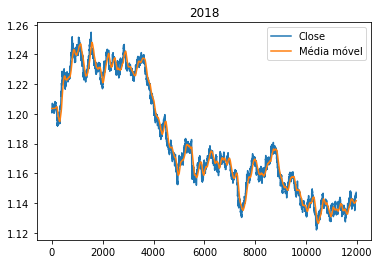

In [6]:
N = 100

# 2017
fig1 = plt.figure(facecolor='white')
plt.title("2017")
ax1 = fig1.add_subplot(111)
rolling_mean1 = pd.Series(df_2017["Close"]).rolling(window=N).mean().iloc[N-1:].values
l = len(rolling_mean1)
for i in range(l, len(df_2017["Close"].values)):
    rolling_mean1 = np.insert(rolling_mean1, 0, rolling_mean1[0], axis=0)
ax1.plot(df_2017["Close"], label='Close')
plt.plot(rolling_mean1, label='Média móvel')
plt.legend()
plt.show()

# 2018
fig1 = plt.figure(facecolor='white')
plt.title("2018")
ax1 = fig1.add_subplot(111)
rolling_mean1 = pd.Series(df_2018["Close"]).rolling(window=N).mean().iloc[N-1:].values
l = len(rolling_mean1)
for i in range(l, len(df_2018["Close"].values)):
    rolling_mean1 = np.insert(rolling_mean1, 0, rolling_mean1[0], axis=0)
ax1.plot(df_2018["Close"], label='Close')
plt.plot(rolling_mean1, label='Média móvel')
plt.legend()
plt.show()

## Fazendo predições

In [7]:
# 2017
predictions_pointbypoint_2017 = model.get_next_n_predictions(x_test_2017, 1, verbose=True)

10338/10338 [==============================] - 113s 11ms/sample


In [28]:
# 2018
predictions_pointbypoint_2018 = model.get_next_n_predictions(x_test_2018, 1, verbose=True)

10967/10967 [==============================] - 74s 7ms/sample


## Avaliando predições
Aqui vou mostrar a capacidade de prever e além disso mostrar o valor previsto frente ao valor real

In [46]:
# Avaliando movimentação (capacidade de prever o movimento cima/baixo do proximo candle)

# 2017
pred_bool_2017 = np.array(predictions_pointbypoint_2017[0, :, 0] > 0).reshape((-1, 1))
y_bool_2017 = np.array(y_test_2017[:, 0] > 0).reshape((-1, 1))
acc_2017 = np.count_nonzero(np.array(pred_bool_2017 == y_bool_2017)) / y_bool_2017.shape[0]

# 2018
pred_bool_2018 = np.array(predictions_pointbypoint_2018[0, :, 0] > 0).reshape((-1, 1))
y_bool_2018 = np.array(y_test_2018[:, 0] > 0).reshape((-1, 1))
acc_2018 = np.count_nonzero(np.array(pred_bool_2018 == y_bool_2018)) / y_bool_2018.shape[0]

In [47]:
def plot_results(title, predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    plt.title(title)
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='Valor real')
    plt.plot(predicted_data, label='Predição')
    plt.legend()
    plt.show()

In [48]:
values_to_normalise_2017 = data_test_2017[:len_test_2017 - seq_len, 0]
values_to_normalise_2018 = data_test_2018[:len_test_2018 - seq_len, 0]

In [49]:
predicted_2017 = np.zeros(values_to_normalise_2017.shape)
for i in range(len(predictions_pointbypoint_2017[0, :, 0])):
    predicted_2017[i] = (1.0 + predictions_pointbypoint_2017[0, i, 0]) * values_to_normalise_2017[i]

In [50]:
predicted_2018 = np.zeros(values_to_normalise_2018.shape)
for i in range(len(predictions_pointbypoint_2018[0, :, 0])):
    predicted_2018[i] = (1.0 + predictions_pointbypoint_2018[0, i, 0]) * values_to_normalise_2018[i]

### 2017

Assertividade na predição do movimento:  99.1681176242987 %


/home/danilo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


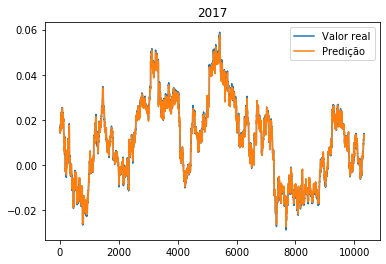

In [51]:
print("Assertividade na predição do movimento: ", acc_2017 * 100, "%")
plot_results("2017", predicted_2017[0, :, 0], y_test_2017[:, 0])

### 2018

In [ ]:
print("Assertividade na predição do movimento: ", acc_2018 * 100, "%")
plot_results("2018",predictions_pointbypoint_2018, y_test_2018)